<a href="https://colab.research.google.com/github/1dhiman/100days-ml/blob/master/2020/fast_filtering_of_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fast Filtering of Datasets


#### The naive way
Let’s suppose we would like to extract all the points that are in a rectangle with between [0.2, 0.4] and [0.4, 0.6]. The naive way to do this would be to loop for each point and to check whether it fulfills this criterion. 

First, we create a function to randomly distribute points in n-dimensional space with numpy, then a function to loop over the entries. To measure computation time we use timeit and visualize the filtering results using matplotlib.

In [0]:
import numpy as np


def random_array(size, dim=3):
    """
    Generate a random array of size size and dimension dim
    """
    return np.random.rand(int(size), dim)


def loop(array):
    """
    Takes a numpy array and isolates all points that are within [0.2,0.4]
    for the first column and between [0.4,0.6] for the second column by
    looping through every point.
    """
    filtered_list = []
    for i in range(len(array)):
        # Check if the point is within the rectangle
        if ((array[i][0] >= 0.2)
            and (array[i][1] >= 0.4)
            and (array[i][0] <= 0.4)
            and (array[i][1] <= 0.6)):
            filtered_list.append(array[i])
    return np.array(filtered_list)


# Generate a random array of size 1e5
array = random_array(1e5)
filtered_array = loop(array)

In [3]:
# Measure code execution with inline magic (Jupyter Notebook)
print('Loop:\t', end='')
%timeit loop(array)

Loop:	10 loops, best of 3: 95.9 ms per loop


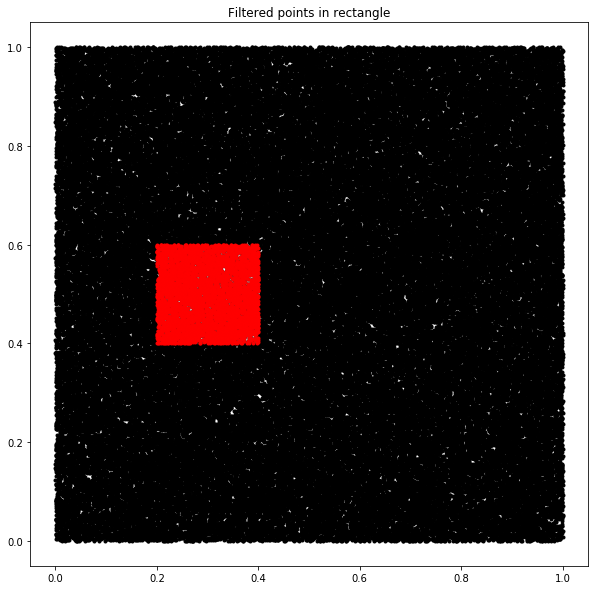

In [4]:
# Plot the results
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.title('Filtered points in rectangle')
plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(filtered_array[:, 0], filtered_array[:, 1], 'r.')
plt.show()

So now let’s benchmark this loop against a pure Python implementation of the loop. Here the difference is to use a list of tuples instead of a numpy array. 

The execution now only took approx. 28 ms, so less than half of the previous execution time. This highlights the potential performance decrease that could occur when using highly optimized packages for rather simple tasks.

In [5]:
def python_loop(random_list):
    """
    Takes a list of tuples and isolates all points that are within [0.2,0.4]
    for the first dimension and between [0.4,0.6] for the second dimension.
    """
    filtered_list = []
    for i in range(len(random_list)):
        if ((random_list[i][0] >= 0.2)
            and (random_list[i][1] >= 0.4)
            and (random_list[i][0] <= 0.4)
            and (random_list[i][1] <= 0.6)):
            filtered_list.append(random_list[i])
    return filtered_list

# Convert the numpy array to a list of tuples
python_list = list(map(tuple, array))

print('Python loop:\t', end='')
%timeit python_loop(python_list)

Python loop:	10 loops, best of 3: 29.6 ms per loop


## Python Functions: List comprehension, Map and Filter

1. List comprehension: List comprehensions are known to perform, in general, better than for loops as they do not need to call the append function at each iteration.
2. Map: This applies a function to all elements of an input list.
3. Filter: This returns a list of elements for which a function returns True

In [6]:
# List comprehension

def list_comprehension(tuple_list):
    """
    Takes a list of tuples and isolates all points that are within [0.2,0.4]
    for the first dimension and between [0.4,0.6] for the second dimension
    using a list comprehension.
    """
    filtered_list = [_ for _ in tuple_list if (_[0] >= 0.2) and (_[1] >= 0.4) and (_[0] <= 0.4) and (_[1] <= 0.6)]
    return filtered_list

print('List comprehension:\t', end='')
%timeit list_comprehension(python_list)

List comprehension:	10 loops, best of 3: 25.4 ms per loop


In [7]:
# Filter method

def filter_fctn(_):
    """
    Takes a tuple and returns True if the first value is within [0.2,0.4]
    while the second value is between [0.4,0.6].
    """
    return (_[0] >= 0.2) and (_[1] >= 0.4) and (_[0] <= 0.4) and (_[1] <= 0.6)

print('Filter:\t\t\t', end='')
%timeit list(filter(filter_fctn, python_list))

Filter:			10 loops, best of 3: 29.8 ms per loop


In [9]:
# Map function

def map_fctn(_):
    """
    Takes a tuple and returns it if the first value is within [0.2,0.4]
    while the second value is between [0.4,0.6].
    """
    if (_[0] >= 0.2) and (_[1] >= 0.4) and (_[0] <= 0.4) and (_[1] <= 0.6):
        return _

print('Map:\t\t\t', end='')
%timeit list(filter(map_fctn, python_list))

Map:			10 loops, best of 3: 30.2 ms per loop


The list comprehension method is slightly faster. This is, as we expected, from saving time not calling the append function. The map and filter function do not show a significant speed increase compared to the pure Python loop.

Thinking about the first implementation of more than 70 ms why should one use numpy in the first place? One thing we can do is to use boolean indexing. Here we perform the check for each criterium column-wise. We can then combine them to a boolean index and directly access the values that are within the range.

In [10]:
def boolean_index(array):
    """
    Takes a numpy array and isolates all points that are within [0.2,0.4] for
    the first dimension and between [0.4,0.6] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] >= 0.2) & (array[:, 1] >= 0.4) & (array[:, 0] <= 0.4) & (array[:, 1] <= 0.6)

    return array[index]

print('Boolean index:\t', end='')
%timeit boolean_index(array)

Boolean index:	The slowest run took 4.99 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 817 µs per loop


The solution using a boolean index only takes approx. 640 µs, so a 50-fold improvement in speed compared to the fastest implementation we tested so far.

## Going faster: Numba

In [0]:
from numba.typed import List
from numba import njit

@njit
def boolean_index_numba(array):
    """
    Takes a numpy array and isolates all points that are within [0.2,0.4] for
    the first dimension and between [0.4,0.6] for the second dimension
    by creating a boolean index. 
    This function will be compiled with numba.
    """
    index = (array[:, 0] >= 0.2) & (array[:,  1] >= 0.4) & (array[:, 0] <= 0.4) & (array[:, 1] <= 0.6)

    return array[index]


@njit
def loop_numba(array):
    """
    Takes a numpy array and isolates all points that are within [0.2,0.4] for
    the first dimension and between [0.4,0.6] for the second dimension.
    This function will be compiled with numba.
    """
    filtered_list = List()
    for i in range(len(array)):
        if ((array[i][0] >= 0.2)
            and (array[i][1] >= 0.4)
            and (array[i][0] <= 0.4)
            and (array[i][1] <= 0.6)):
            filtered_list.append(array[i])
    return filtered_list

In [12]:
filtered_list = boolean_index_numba(array)
print('Boolean index with numba:\t', end='')
%timeit boolean_index_numba(array)

Boolean index with numba:	1000 loops, best of 3: 440 µs per loop


In [13]:
filtered_list = loop_numba(array)
print('Loop with numba:\t\t', end='')
%timeit loop_numba(array)

Loop with numba:		1000 loops, best of 3: 1.28 ms per loop


After compiling the function with LLVM, even the execution time for the fast boolean filter is half and only takes approx. 340 µs. More interestingly, even the inefficient loop from the beginning is now sped up from 72 ms to less than 1 ms, highlighting the potential of numba for even poorly optimized code.

## Data in Tables: Pandas

In [18]:
import pandas as pd
df = pd.DataFrame({'x': array[:, 0], 'y': array[:, 1], 'z': array[:, 2]})

# Pandas query
print('Pandas Query:\t\t', end='')
%timeit df.query('x >= 0.2 and x <= 0.4 and y >= 0.4 and y <= 0.6')

Pandas Query:		100 loops, best of 3: 4.39 ms per loop


In [19]:
# Pandas eval
print('Pandas Eval:\t\t', end='')
%timeit df.eval('x >= 0.2 and x <= 0.4 and y >= 0.4 and y <= 0.6')

Pandas Eval:		100 loops, best of 3: 3.61 ms per loop


In [20]:
# Boolean index
print('Pandas Boolean index:\t', end='')
%timeit df[(df['x'] >= 0.2) & (df['y'] >= 0.4) & (df['x'] <= 0.4) & (df['y'] <= 0.6)]

Pandas Boolean index:	100 loops, best of 3: 3.26 ms per loop


Arguably, the execution time is much faster than our initial loop that was not optimized. However, it is significantly slower than the optimized versions. It is, therefore, suitable for initial exploration but should then be optimized.

## Quantitative Comparison I

In [22]:
! pip install perfplot

100%|██████████| 20/20 [00:36<00:00,  3.31s/it]


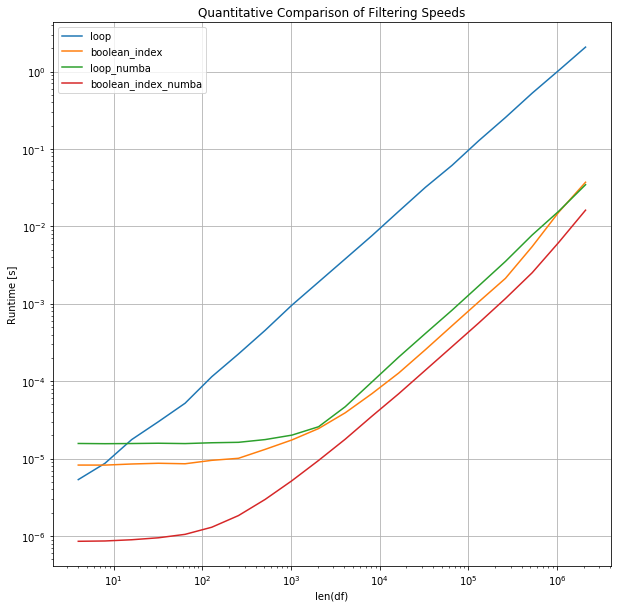

In [23]:
import perfplot

plt.figure(figsize=(10, 10))
plt.title('Quantitative Comparison of Filtering Speeds')
perfplot.show(
    setup=random_array,
    kernels=[loop, boolean_index, loop_numba, boolean_index_numba],
    n_range=[2**k for k in range(2, 22)],
    logx=True,
    logy=True,
    equality_check=False,
    xlabel='len(df)')

## More Queries and Larger Datasets

We can do so by sorting the data first and then being able to select a subsection using an index. The idea here is that the time to sort the array should be compensated by the time saved of repeatedly searching only a smaller array.

We rewrite the `boolean_index_numba` function to accept arbitrary reference volumes in the form `[xmin, xmax]`, `[ymin, ymax]` and `[zmin, zmax]`. We define a wrapper named `multiple_queries` that repeatedly executes this function. The comparison will be against the function `multiple_queries_index` that sorts the data first and only passes a subset to `boolean_index_numba_multiple`.

In [0]:
@njit
def boolean_index_numba_multiple(array, xmin, xmax, ymin, ymax, zmin, zmax):
    """
    Takes a numpy array and isolates all points that are within [xmin, xmax]
    for the first dimension, between [ymin, ymax] for the second dimension
    and [zmin, zmax]  for the third dimension by creating a boolean index.
    This function will be compiled with numba.
    """
    index = ((array[:, 0] > xmin) & (array[:,  1] > ymin) & (array[:, 2] > zmin)
             & (array[:, 0] < xmax) & (array[:, 1] < ymax) & (array[:, 2] < zmax))

    return array[index]


def multiple_queries(data, delta=0.1):
    """
    Takes an array and a list of query points to filter points that are within 
    a delta to the query points.
    """
    array, query_points = data

    count = 0
    for i in range(len(query_points)):
        point = query_points[i]
        xmin, xmax = point[0]-delta, point[0]+delta
        ymin, ymax = point[1]-delta, point[1]+delta
        zmin, zmax = point[2]-delta, point[2]+delta

        filtered_list = boolean_index_numba_multiple(array, xmin, xmax, ymin, ymax, zmin, zmax)
        count += len(filtered_list)

    return count

def multiple_queries_index(data, delta=0.1):
    """
    Takes an array and a list of query points to filter points that are within a delta to the query points.
    Sorts the array beforehand and slices a subarray.
    """
    array, query_points = data
    # Sort the array on the first dimension
    sorted_array = array[np.argsort(array[:, 0])]
    count = 0

    for point in query_points:
        xmin, xmax = point[0]-delta, point[0]+delta
        ymin, ymax = point[1]-delta, point[1]+delta
        zmin, zmax = point[2]-delta, point[2]+delta

        min_index = np.searchsorted(sorted_array[:, 0], xmin, side='left')
        max_index = np.searchsorted(sorted_array[:, 0], xmax, side='right')

        filtered_list = boolean_index_numba_multiple(sorted_array[min_index:max_index], xmin, xmax, ymin, ymax, zmin, zmax)

        count += len(filtered_list)

    return count

In [25]:
array = random_array(1e5,3)
query_points = random_array(1e3, 3)
data = (array, query_points)

print('Multiple queries:\t\t', end='')
%timeit multiple_queries(data)
print('Multiple queries with subset:\t', end='')
%timeit multiple_queries_index(data)

print('Count for multiple_queries: {:,}'.format(multiple_queries(data)))
print('Count for multiple_queries: {:,}'.format(multiple_queries_index(data)))

Multiple queries:		1 loop, best of 3: 536 ms per loop
Multiple queries with subset:	10 loops, best of 3: 144 ms per loop
Count for multiple_queries: 686,645
Count for multiple_queries: 686,645


## More Structure: k-d-trees

The idea to pre-structure the data to increase access times can be further expanded, e.g. one could think of sorting again on the subsetted data. One could think of creating n-dimensional bins to efficiently subset data.
One approach that extends this idea and uses a tree structure to index the data is the k-d-Tree that allows the rapid lookup of neighbors for a given point.

> In computer science, a k-d tree is a space-partitioning data structure for organizing points in a k-dimensional space. k-d trees are a useful data structure for several applications, such as searches involving a multidimensional search key.

Luckily, we don’t need to implement the k-d-tree ourselves but can use an existing implementation from scipy. It not only has a pure Python implementation but also a C-optimized version that we can use for this approach. It comes with a built-in function called `query_ball_tree` that allows searching all neighbors within a certain radius. As we are searching for points within a square around a given point we only need to set the Minkowski norm to `Chebyshev (p=’inf’)`.


In [27]:
from scipy.spatial import cKDTree

def kdtree(data, delta=0.1):
    """
    Constructs a 2D k-d-tree from the input array and queries the points within a square around a given point.
    """
    array, query_points = data
    tree = cKDTree(array)
    count = 0
    for point in query_points:
        idx = tree.query_ball_point((point[0], point[1], point[2]), 0.1, p=np.float('inf'))
        filtered = array[idx]
        count += len(filtered)

    return count

array, query_points = data
tree = cKDTree(array)

# Time the construction of the tree
print('Tree construction:\t', end='')
%timeit cKDTree(array)

# Time the querying time
point = query_points[0]
print('Query time:\t\t', end='')
%timeit tree.query_ball_point((point[0], point[1], point[2]), 0.1, p=np.float('inf'))

# Time the total time for the whole array
print('Total time:\t\t', end='')
%timeit kdtree(data)

print('Count for k-d-tree: {:,}'.format(kdtree(data)))


Tree construction:	10 loops, best of 3: 44.2 ms per loop
Query time:		10000 loops, best of 3: 176 µs per loop
Total time:		1 loop, best of 3: 277 ms per loop
Count for k-d-tree: 686,645


## Quantitative Comparison II

100%|██████████| 20/20 [07:25<00:00, 97.21s/it]


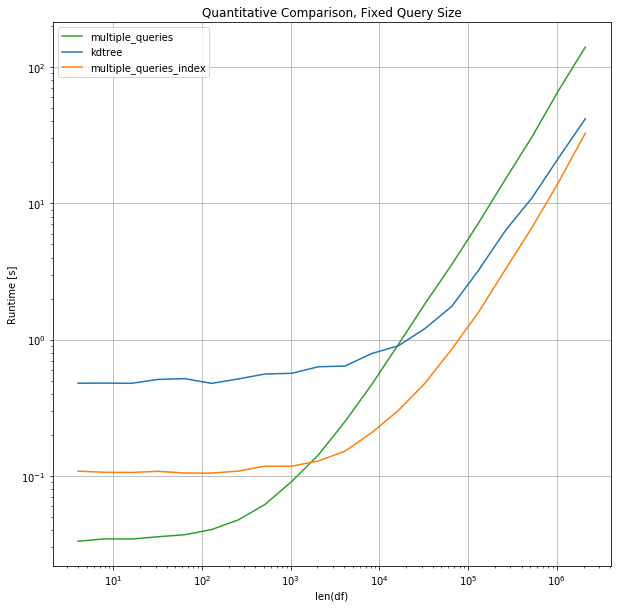

In [28]:
def fixed_query(size):
    """
    Returns a random array of given size and
    a fixed number of random query points.
    """
    array = random_array(size)
    query_points = random_array(1e4)
    return (array, query_points)


plt.figure(figsize=(10, 10))
plt.title('Quantitative Comparison, Fixed Query Size')
perfplot.show(
    setup=fixed_query,
    kernels=[kdtree, multiple_queries_index, multiple_queries],
    n_range=[2**k for k in range(2, 22)],
    logx=True,
    logy=True,
    equality_check=False,
    xlabel='len(df)')
plt.show()

## Summary 
Testing filtering speed for different approaches highlights how code can be effectively optimized. 
* Pure Python can be fast.
* Numba is very beneficial even for non-optimized loops.
* Pandas onboard functions can be faster than pure Python but also have the potential for improvement.
* When performing large queries on large datasets sorting the data is beneficial.
* k-d-trees provide an efficient way to filter in n-dimensional space when having large queries.

When having files that are too large to load in memory, chunking the data or generator expressions can be handy. 

[Source](https://towardsdatascience.com/speeding-up-python-code-fast-filtering-and-slow-loops-8e11a09a9c2f)